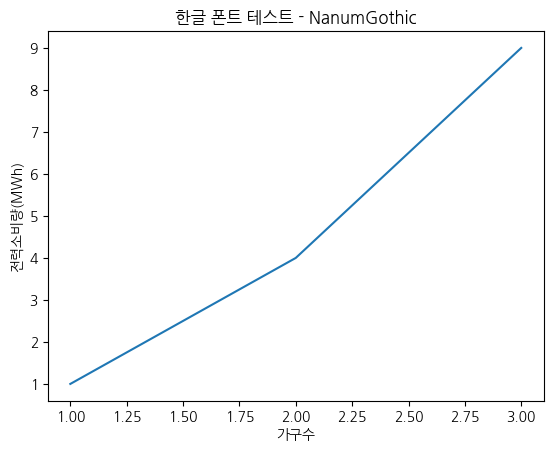

In [ ]:
# 1) 나눔고딕 설치
!apt-get -qq install -y fonts-nanum > /dev/null

# 2) Matplotlib에 '파일 경로로' 폰트를 직접 등록 (재시작 불필요)
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import os

# 나눔고딕 파일 경로 (콜랩 기본 경로)
candidates = [
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
    "/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf",
    "/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf",
]
font_path = next((p for p in candidates if os.path.exists(p)), None)

if font_path is None:
    # 대체로 Noto CJK도 시도
    !apt-get -qq install -y fonts-noto-cjk > /dev/null
    candidates_noto = [
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",
        "/usr/share/fonts/opentype/noto/NotoSansCJKkr-Regular.otf",
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc",
    ]
    font_path = next((p for p in candidates_noto if os.path.exists(p)), None)

if font_path is None:
    raise FileNotFoundError("한글 폰트 파일을 찾지 못했습니다. fonts-nanum 또는 fonts-noto-cjk 설치를 확인해주세요.")

# 인라인 등록 → 즉시 사용 가능
fm.fontManager.addfont(font_path)

# 폰트 패밀리 이름은 보통 파일 내 이름과 동일 (NanumGothic 또는 Noto Sans CJK KR)
# 안전하게 이름 후보를 몇 개 돌려서 먼저 적용되는 걸로 사용
possible_families = ["NanumGothic", "Nanum Gothic", "Noto Sans CJK KR", "Noto Sans CJK"]
for fam in possible_families:
    try:
        rcParams["font.family"] = fam
        rcParams["axes.unicode_minus"] = False
        # 테스트 플롯
        plt.figure()
        plt.title(f"한글 폰트 테스트 - {fam}")
        plt.plot([1,2,3], [1,4,9])
        plt.xlabel("가구수")
        plt.ylabel("전력소비량(MWh)")
        plt.show()
        break
    except Exception as e:
        continue

In [ ]:
import pandas as pd
# df설정 및 전처리 함수 작성
def load_home(filename, year):
    df = pd.read_csv(filename, encoding="cp949")
    df = df[["구분", "주거용"]].copy()
    df = df[df["구분"].notna()]
    df["구분"] = df["구분"].astype(str).str.strip()
    df["주거용"] = pd.to_numeric(df["주거용"], errors="coerce")
    # 합계/계/개성 제거
    df = df[~df["구분"].str.contains("합계|계|개성", na=False)]
    return df.rename(columns={"구분": "지역", "주거용": str(year)})

# 파일 이름을 직접 지정 (업로드한 파일명과 똑같이 써야 함)
df2018 = load_home("18년가정용.csv", 2018)
df2019 = load_home("19년가정용.csv", 2019)
df2020 = load_home("20년가정용.csv", 2020)
df2021 = load_home("21년가정용.csv", 2021)
df2022 = load_home("22년가정용.csv", 2022)
df2023 = load_home("23년가정용.csv", 2023)


In [ ]:
from functools import reduce

dfs = [df2018, df2019, df2020, df2021, df2022, df2023]  # 연도별 DataFrame 리스트
df_wide = reduce(lambda L, R: pd.merge(L, R, on="지역", how="outer"), dfs)  # '지역' 기준으로 모두 합치기 (wide 형태)

# 보기 좋게 정렬
df_wide = df_wide.sort_values("지역").reset_index(drop=True)  # 지역 이름순 정렬 + 인덱스 재설정

print(df_wide.head())  # 앞 5행 확인

df_wide.to_csv("주거용_판매전력량_2018_2023.csv", index=False, encoding="utf-8-sig")

   지역        2018          2019        2020        2021        2022  \
0  강원   2060563.0  2.081091e+06   2197106.0   2289719.0   2332245.0   
1  경기  18016468.0  1.822849e+07  19387551.0  20775255.0  21128150.0   
2  경남   4482335.0  4.475992e+06   4718536.0   4826057.0   4863308.0   
3  경북   3498309.0  3.466430e+06   3631035.0   3709248.0   3763344.0   
4  광주   2056435.0  2.038974e+06   2154034.0   2215918.0   2249750.0   

         2023  
0   2347691.0  
1  21681941.0  
2   4912623.0  
3   3737831.0  
4   2261231.0  


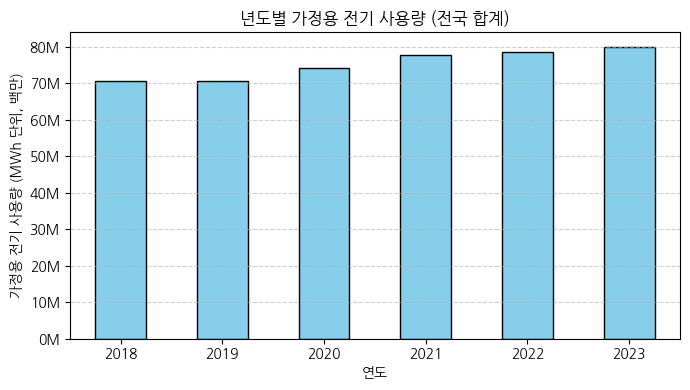

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 1) '지역' 컬럼 제외하고 연도 컬럼만 뽑기
year_cols = [c for c in df_wide.columns if c != "지역"]

# 2) 연도별 합계 (전국 합계)
totals_by_year = df_wide[year_cols].sum()

# 3) 막대그래프 생성
plt.figure(figsize=(7,4))
ax = totals_by_year.plot(kind="bar", color="skyblue", edgecolor="black")

# 🔹 y축 숫자 단위를 백만(M) 단위로 변환
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x/1e6)}M"))

plt.title("년도별 가정용 전기 사용량 (전국 합계)")
plt.xlabel("연도")
plt.ylabel("가정용 전기 사용량 (MWh 단위, 백만)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


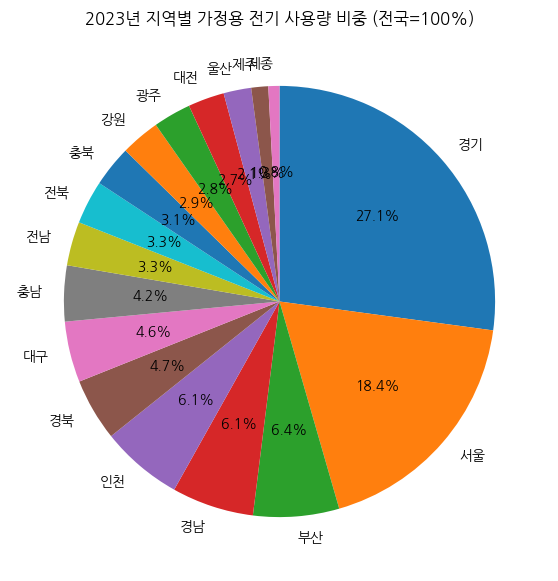

In [ ]:
import matplotlib.pyplot as plt

# 1) 기준 연도 설정
target_year = "2023"

# 2) 해당 연도 데이터 (지역, 값)
data_yr = df_wide[["지역", target_year]].dropna()

# 3) 전국 합계 대비 비율(%) 계산
data_yr["비중(%)"] = data_yr[target_year] / data_yr[target_year].sum() * 100

# 4) 비중이 큰 순으로 정렬
data_sorted = data_yr.sort_values(by="비중(%)", ascending=False)

# 5) 파이차트로 시각화
plt.figure(figsize=(7,7))
plt.pie(
    data_sorted["비중(%)"],
    labels=data_sorted["지역"],
    autopct="%.1f%%",
    startangle=90,
    counterclock=False
)
plt.title(f"{target_year}년 지역별 가정용 전기 사용량 비중 (전국=100%)")
plt.show()
